In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import glob
import os
import matplotlib.pyplot as plt
import math

#Umap
import matplotlib.pyplot as plt
from umap.umap_ import UMAP

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE

#hdbscan
import hdbscan

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
# Import
path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)
df = df.fillna('')

# Filter out the rows with missing values
df_filtered = df[df.inventory_year != '']

# 10'000 sample points for fast plotting
df = df.sample(10000)
df_filtered = df_filtered.sample(10000)

In [67]:
# text cols for wordclouds, cluster cols for clustering
text_cols = ['text', 'text_3', 'text_2', 'text_1']
cluster_cols = ['sig_lev_1', 'sig_lev_2', 'sys']

# Perform one-hot encoding on the cluster_cols
df_cluster_1 = pd.get_dummies(df[cluster_cols[0]])
df_cluster_2 = pd.get_dummies(df[cluster_cols[:2]])


# Import Functions

In [46]:
#Normalize 
def normalize(emb):

    embedding = emb * 100 # Multiply by 100
    embedding = align_points_to_grid(embedding)

    # Swap axes for horizontal position

    ptp = np.ptp(embedding, axis=0)
    if ptp[1]> ptp[0]:
        embedding[:, [1, 0]] = embedding[:, [0, 1]]

    # Set range of values normalized to dimension with higher extent

    extent = (embedding[:,0].min(), embedding[:,0].max()) if (embedding[:,0].max() - embedding[:,0].min()) > (embedding[:,1].max() - embedding[:,1].min()) else (embedding[:,1].min(), embedding[:,1].max())
    resolution = (-1000, 1000)

    embedding[:, 0] = np.interp(embedding[:,0], extent, resolution)
    embedding[:, 1] = np.interp(embedding[:,1], extent, resolution)

    # # Set origin at the middle

    # ptp = np.ptp(embedding, axis=0)  
    # embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
    # embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

    embedding = embedding.astype(int) # Set integer

    return embedding

def normalize_cluster(embedding, cluster_extent):
    # Multiply by 100
    embedding = embedding * 100
    embedding = align_points_to_grid(embedding)

    # Swap axes for horizontal position
    ptp = np.ptp(embedding, axis=0)
    if ptp[1] > ptp[0]:
        embedding[:, [1, 0]] = embedding[:, [0, 1]]

    # Set range of values normalized to dimension with higher extent
    extent = (cluster_extent[0], cluster_extent[1])
    resolution = (-1000, 1000)
    embedding[:, 0] = np.interp(embedding[:, 0], extent, resolution)
    embedding[:, 1] = np.interp(embedding[:, 1], extent, resolution)

    # Set origin at the middle
    # ptp = np.ptp(embedding, axis=0)  
    # embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
    # embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

    embedding = embedding.astype(int) # Set integer
    return embedding


In [49]:
#Plotting

def plot_embeddings(embeddings, param_names, num_cols = 2):
    # Create a subplot grid for the scatterplots
    num_plots = len(embeddings)
    num_cols = num_cols
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()

    for i, (object, embedding) in enumerate(embeddings):
        # Normalize and plot the embedding
        embedding = normalize(embedding)

        # Create a scatterplot
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df.signature.astype(str).str[0], hue_order=order, ax=axs[i], s=10)

        # Set the title of the plot based on the specified parameters
        title_params = {param_name: getattr(object, param_name) for param_name in param_names}
        title_str = ', '.join(f'{param_name}: {title_params[param_name]}' for param_name in param_names)
        axs[i].set_title(title_str)

    # Show the scatterplots
    plt.show()


def plot_embeddings_year(embeddings, param_names, df, num_cols = 2):
    # Create a subplot grid for the scatterplots
    num_plots = len(embeddings)
    num_cols = num_cols
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()

    for i, (object, embedding) in enumerate(embeddings):
        # Normalize and plot the embedding
        embedding = normalize(embedding)

        # hue
        order = sorted([(f'{year}0') for year in df.inventory_year.astype(str).str[:3].unique().tolist()])
        colours = sns.color_palette("coolwarm", n_colors=len(order))
        hue = df.inventory_year.astype(str).str[:3].map(lambda x:  f'{x}0')

        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=hue, hue_order=order, ax=axs[i], s=10, palette=colours)

        # Set the title of the plot based on the specified parameters
        title_params = {param_name: getattr(object, param_name) for param_name in param_names}
        title_str = ', '.join(f'{param_name}: {title_params[param_name]}' for param_name in param_names)
        axs[i].set_title(title_str)

    # Show the scatterplots
    plt.show()



def get_cluster_extent(embedding, cluster_indices):
    cluster_embedding = embedding[cluster_indices]
    extent = np.zeros((2, cluster_embedding.shape[1]))
    extent[0] = np.min(cluster_embedding, axis=0)
    extent[1] = np.max(cluster_embedding, axis=0)
    return extent

def plot_cluster_embeddings(df, clusters, embeddings, param_names, num_cols=2):
    # Create a subplot grid for the scatterplots
    num_plots = len(clusters)
    num_cols = num_cols
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()

    # Loop over clusters and plot the corresponding embeddings
    for i, cluster in enumerate(clusters):

        df_cl = df.iloc[cluster]
        # Extract the embeddings for the current cluster
        object = embeddings[i][0]
        embedding = embeddings[i][1]
        
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df_cl.sig_lev_2, ax=axs[i], s=10)

        # Set the title of the plot based on the specified parameters
        title_params = {param_name: getattr(object, param_name) for param_name in param_names}
        title_str = ', '.join(f'{param_name}: {title_params[param_name]}' for param_name in param_names)
        axs[i].set_title(title_str)

    # Show the scatterplots
    plt.show()

In [64]:
# Clusters

def cluster_embeddings(embedding):

    clusterer = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_method ='leaf')

    clusterer.fit(embedding)
    clusters = clusterer.labels_

    #Grouping by cluster
    values = set(clusters)
    if -1 in values: values.remove(-1)
    clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

    return clusters


def run_umap_on_clusters(df, clusters, n_neighbors = 10, metric = 'hamming', min_dist = 0.0):
    embeddings = []
    for cluster in clusters:
        # extract data for current cluster
        data = df.iloc[cluster, :].values
        # apply UMAP to the data
        
        umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, 
                                    spread=1.0, random_state=42, verbose=False)
        x_umap = umap.fit_transform(data)
        embeddings.append((umap, x_umap))
    return embeddings 

## Running umap on sig_lev_1

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


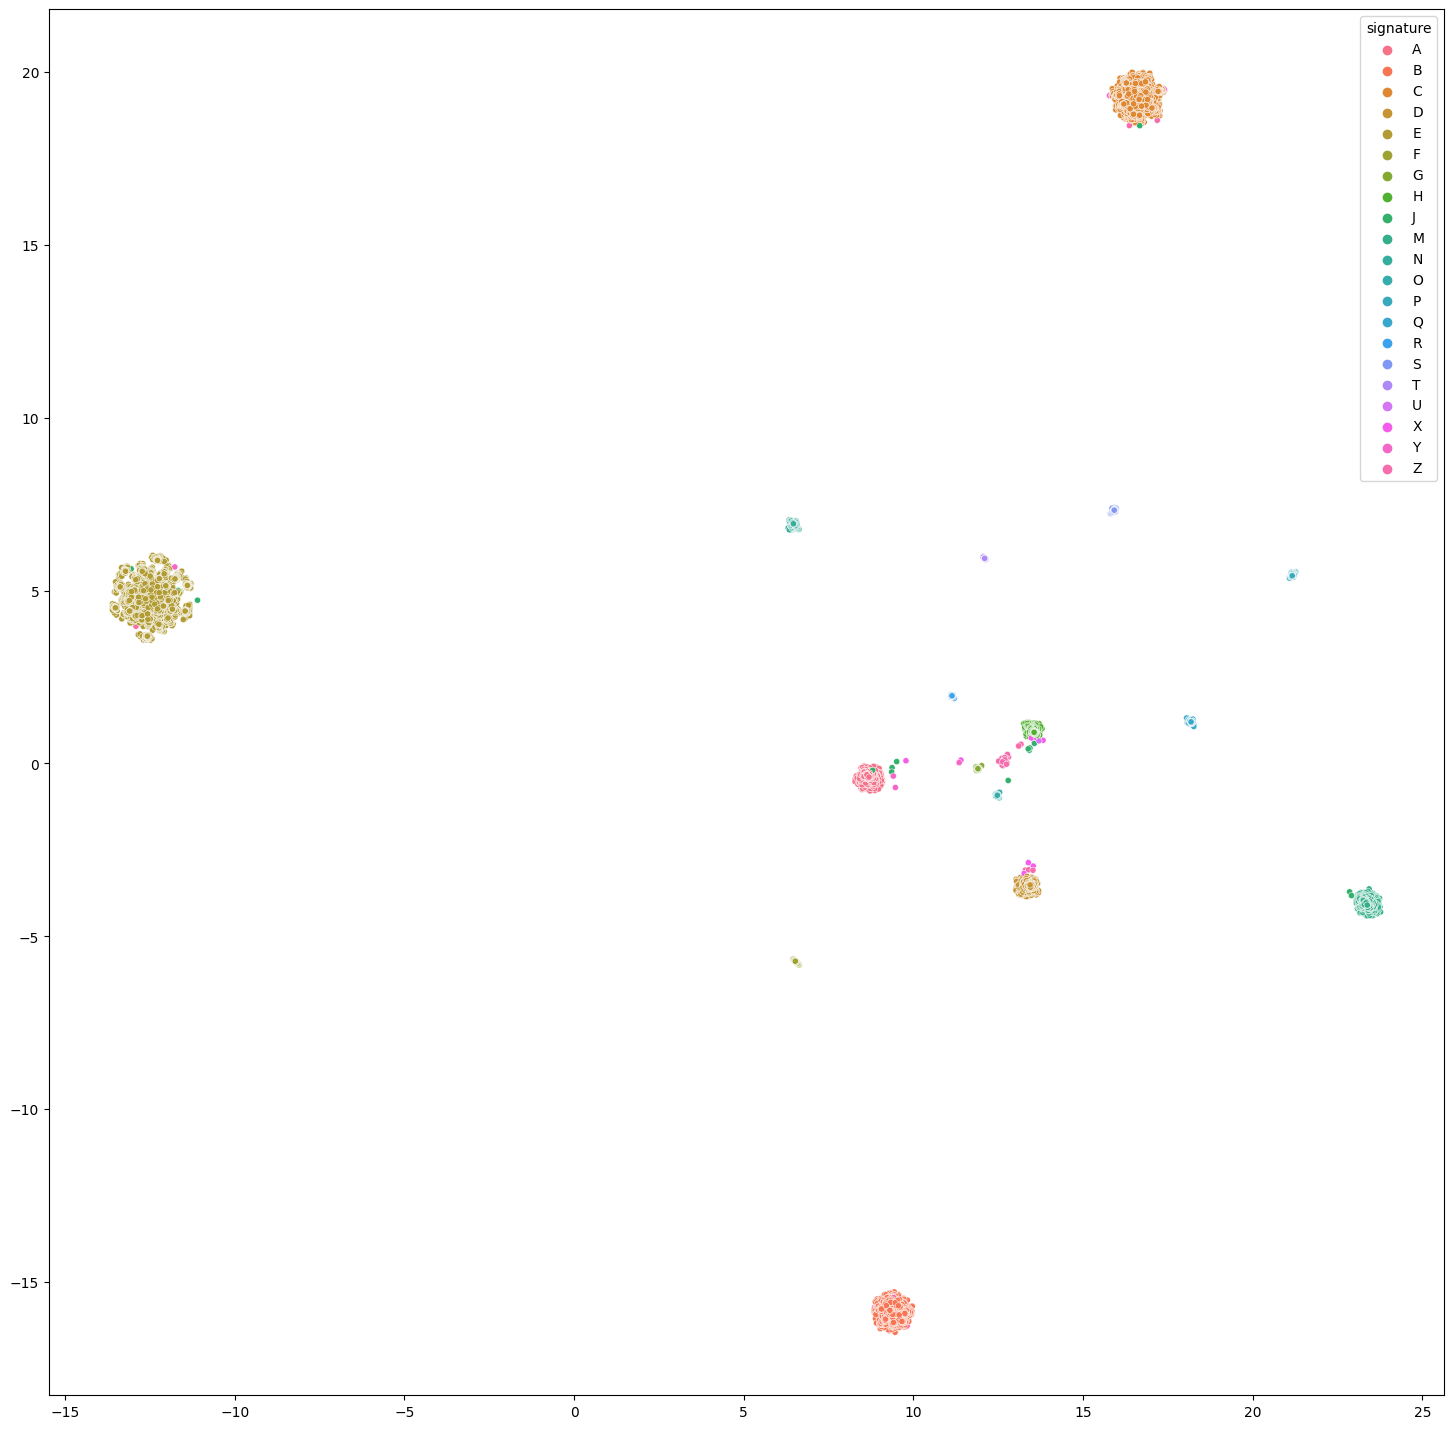

In [69]:
n_neighbors = 100
metric = 'hamming'
min_dist = 0.0

umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, 
                                 spread=1.0, random_state=42, verbose=False)
x_umap = umap.fit_transform(df_cluster_1)

embedding = x_umap

#Plot the embedding
fig, ax = plt.subplots(figsize=(18, 18))

# Get the unique values in the column and sort them alphabetically
order = sorted(df.signature.astype(str).str[0].unique())
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df.signature.astype(str).str[0], hue_order=order, ax=ax, s=20)

plt.show()

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


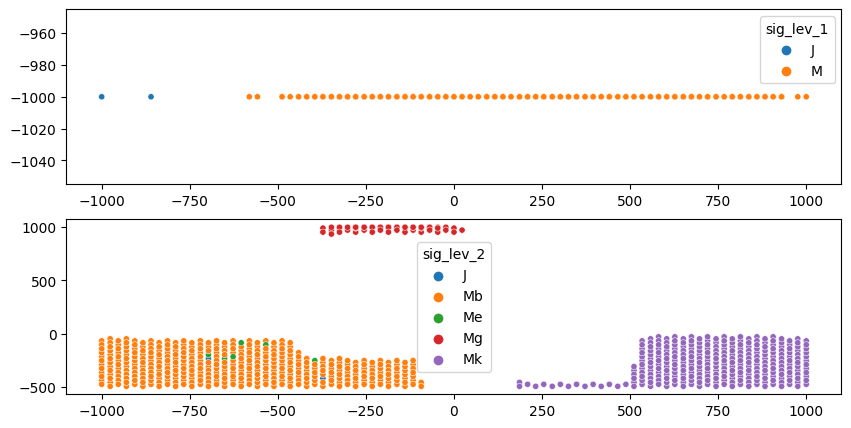

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


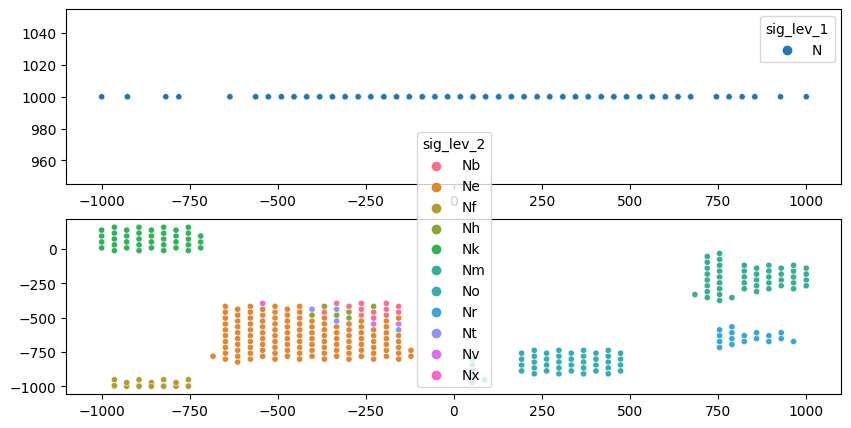

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


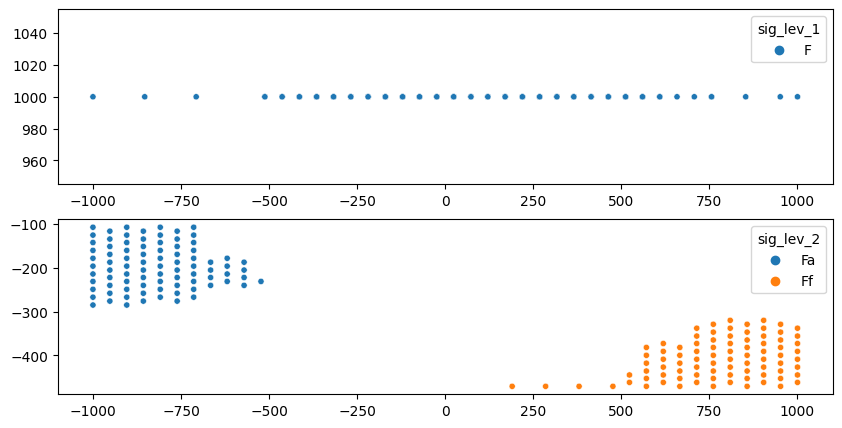

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


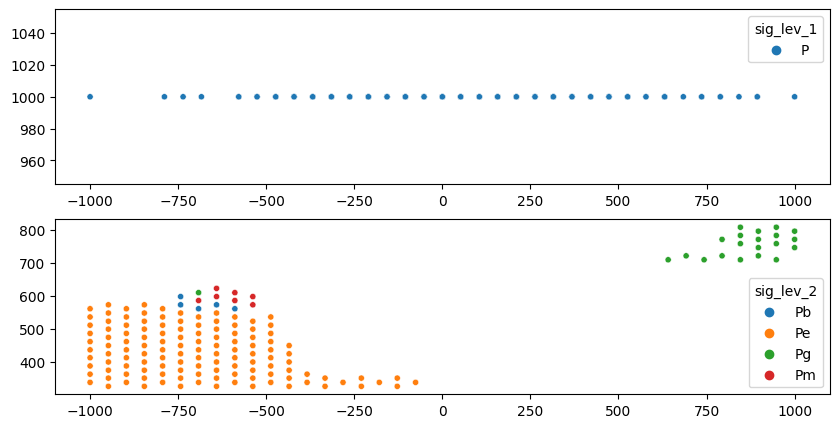

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


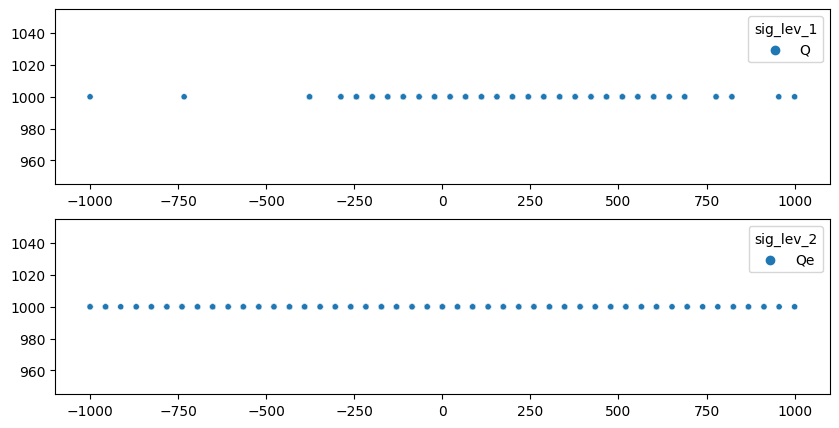

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


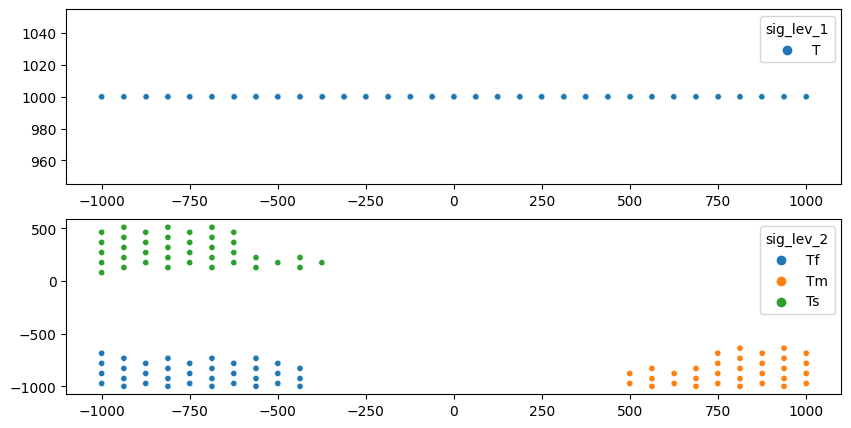

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


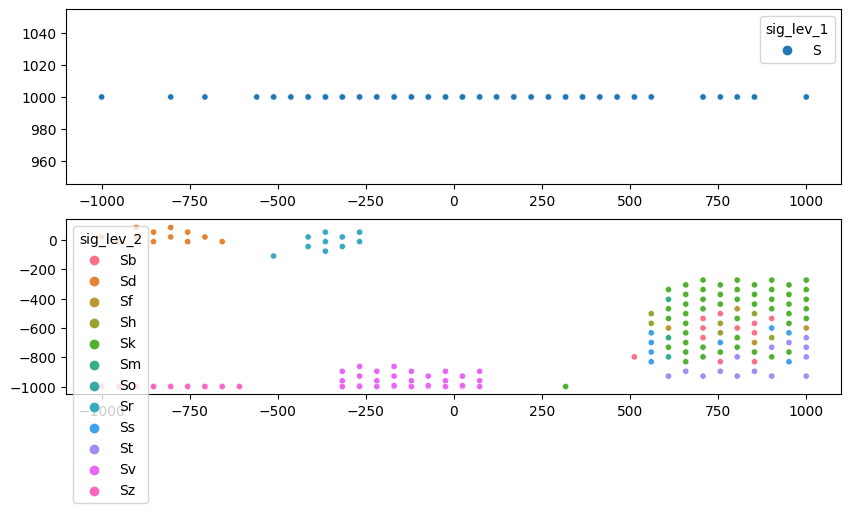

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


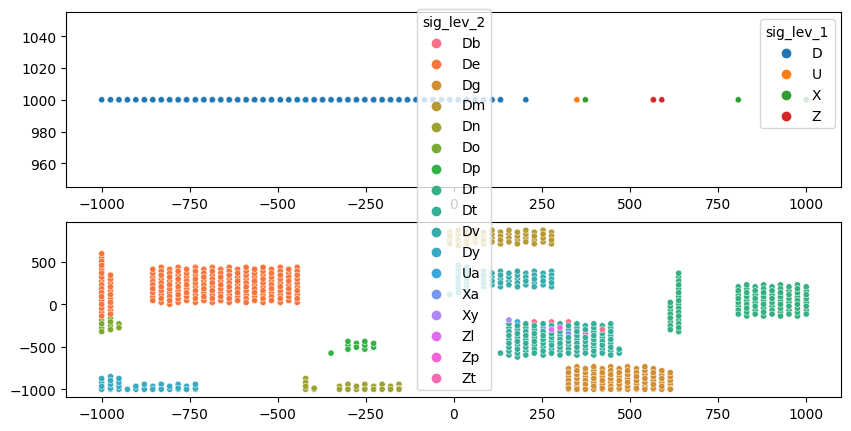

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


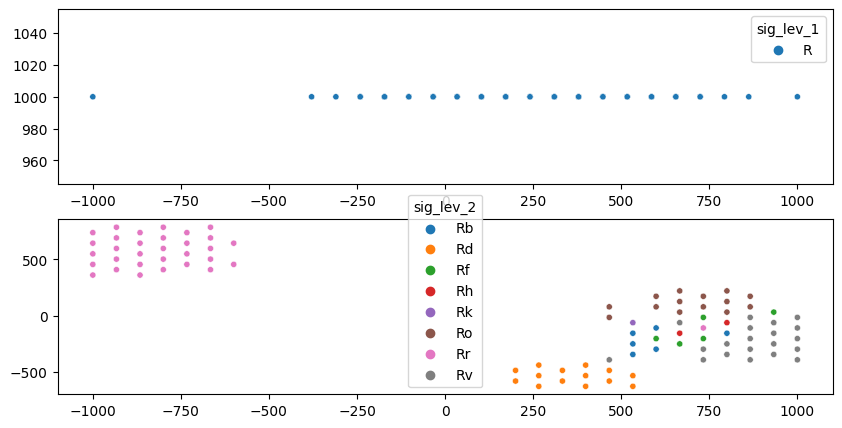

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


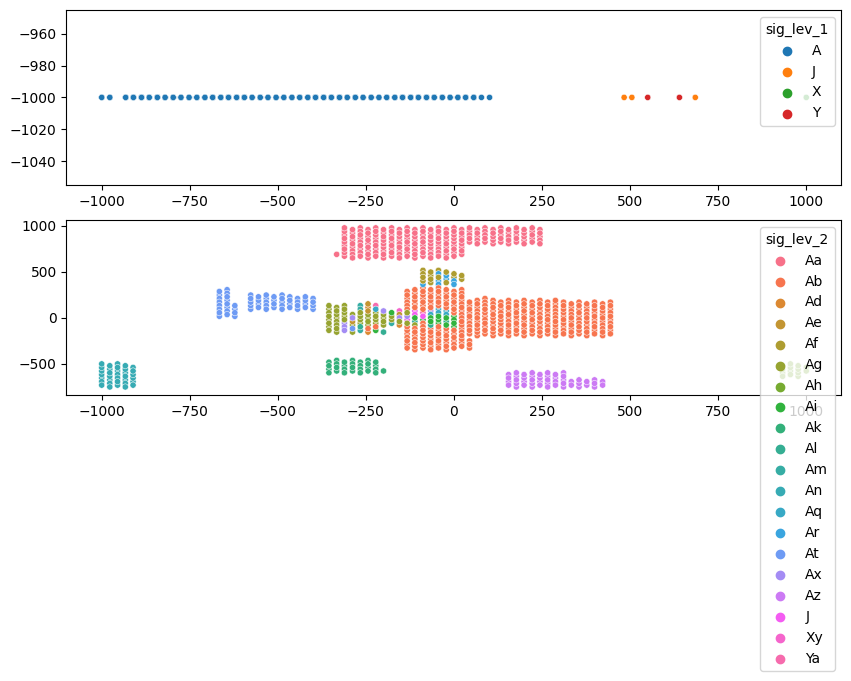

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


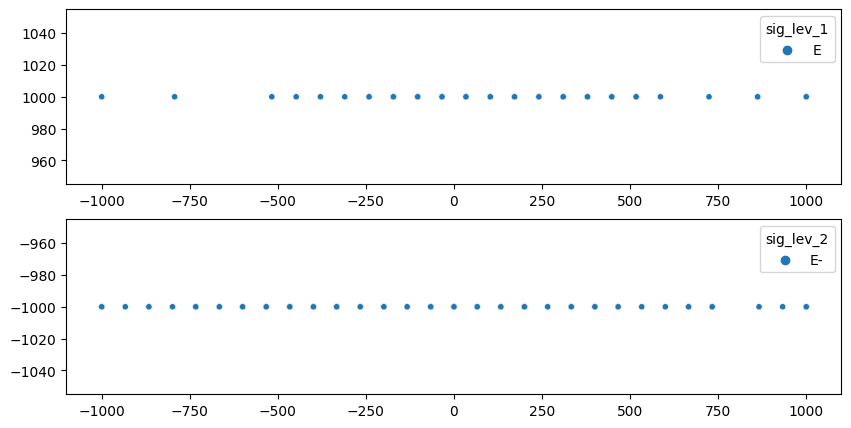

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


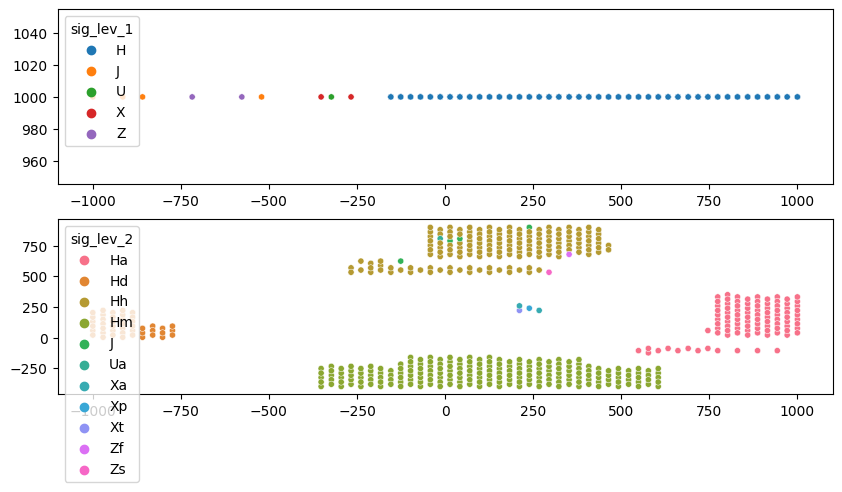

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


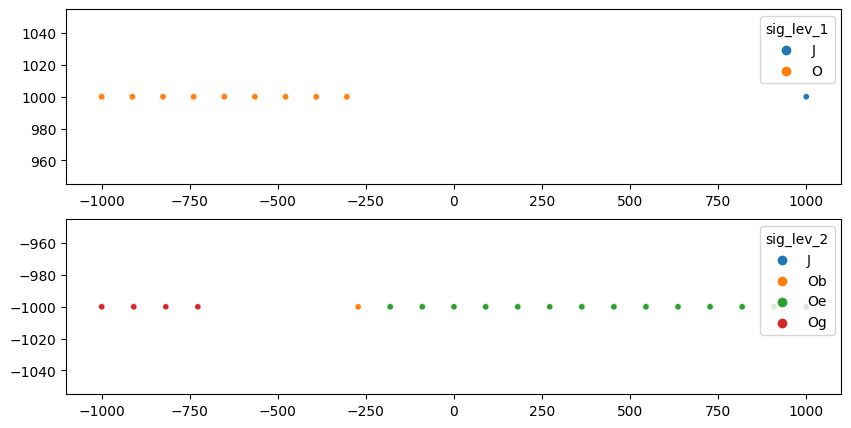

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


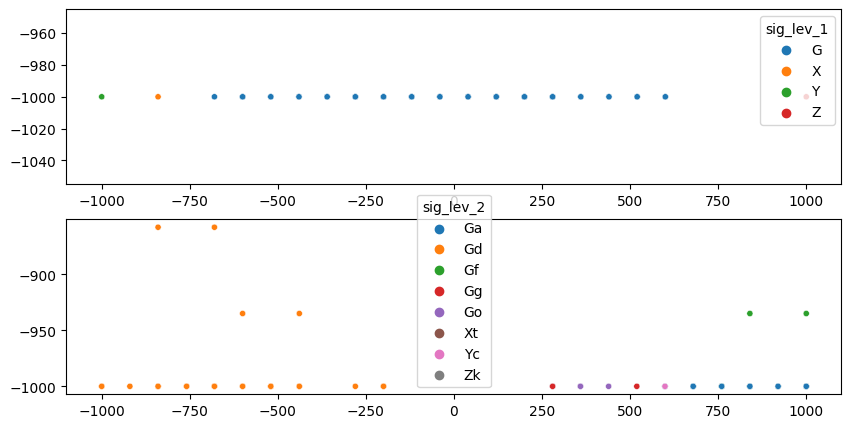

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


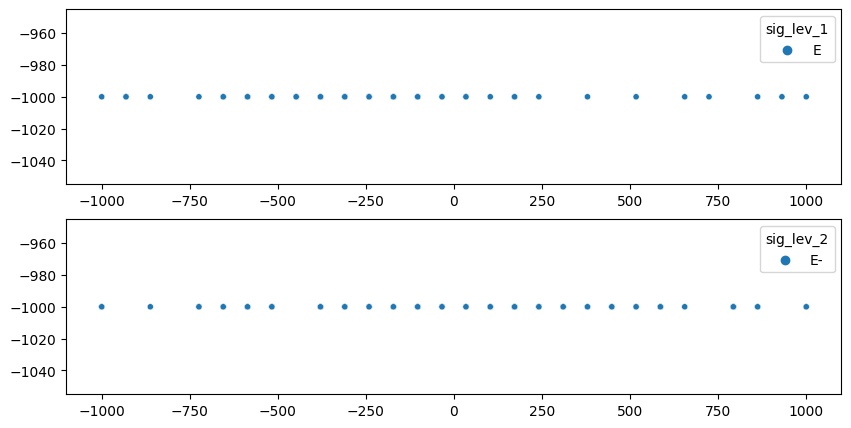

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


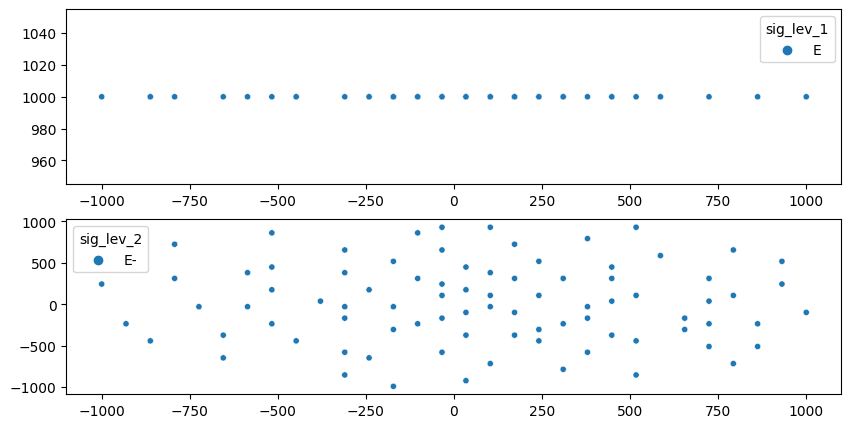

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


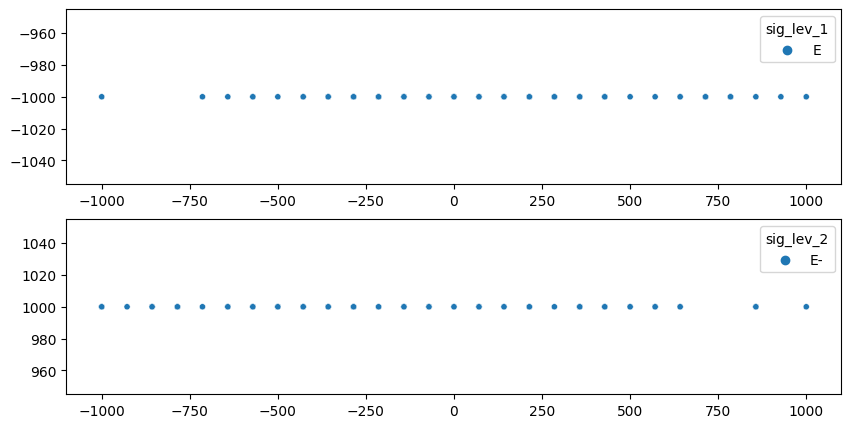

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


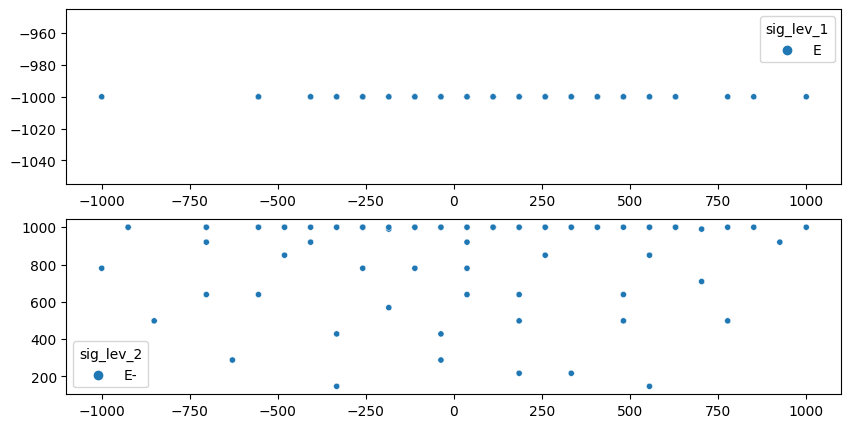

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


KeyboardInterrupt: 

In [73]:
clusters = cluster_embeddings(embedding)

n_neighbors = 10
metric = 'hamming'
min_dist = 0.0

for i, cluster in enumerate(clusters):

    cluster_extent = get_cluster_extent(embedding, cluster)
    
    # extract data for current cluster
    data = df_cluster_2.iloc[cluster, :]
    rows = df.iloc[cluster, :]
    cluster_emb = embedding[cluster,:]

    # apply UMAP to the cluster again  
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, 
                                    spread=1.0, random_state=42, verbose=False)
    x_umap = umap.fit_transform(data)
    
    #Normalize to fit the coordinates of the cluster
    embedding_2 = x_umap
    #Plot the embedding
    fig, ax = plt.subplots(2, figsize=(10, 5))

    # Get the unique values in the column and sort them alphabetically
    order = sorted(rows.sig_lev_1.unique())
    sns.scatterplot(x=cluster_emb[:, 0], y=cluster_emb[:, 1], hue=rows.sig_lev_1, hue_order=order, ax=ax[0], s=20)
    order = sorted(rows.sig_lev_2.unique())
    sns.scatterplot(x=embedding_2[:, 0], y=embedding_2[:, 1], hue=rows.sig_lev_2, hue_order=order, ax=ax[1], s=20)

    plt.show()

    